# **Tutorial Topic Modeling - CARMA 2024**

![image info](https://pbs.twimg.com/media/GIKiC8jWkAAdxzy?format=jpg&name=4096x4096)

<hr>

## **Setup**

### **Imports**

In [13]:
# These might take a minute or two!
%pip install accelerate transformers bertopic top2vec[sentence_transformers]
%pip install -i https://pypi.org/simple/ bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6

In [14]:
import warnings
import os
from torch import cuda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import timeit
import platform
from pathlib import Path
from datetime import datetime

# Tokenization tools
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import re

# Scikit-Learn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

# Coherence
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import tokenize

# Word Clouds
from wordcloud import WordCloud

#**Initialization**

In [15]:
warnings.filterwarnings('ignore')
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
print(device)

cuda:0


### **Globals**

In [16]:
seed          : int  = 42
limit_dataset : int  = 10000  # 'None' for no limiting
llm_model_id  : str  = 'NousResearch/Meta-Llama-3-8B-Instruct'
from_colab    : bool = True

### **Coherence Metrics**

The coherence of a topic modeling model, such as LDA (Latent Dirichlet Allocation), measures how semantically correlated the words within each topic are. There are various methods to calculate the coherence of a topic modeling model. One of the most commonly used methods is word coherence, which evaluates coherence based on the co-occurrence of words in documents.

### Steps to Calculate Coherence in LDA

1. **Extraction of Topic Words**:
   - Identify the main words (typically the top \(N\) words) for each topic from the LDA model. These are the words with the highest probabilities within the topic.

2. **Definition of Co-occurrence Measure**:
   - Choose a co-occurrence measure, which can be based on a context window within the documents or the entire document. The context window is commonly used.
   - Calculate the frequency with which the words appear together in the chosen context.

3. **Calculation of Coherence**:
   - For each topic, consider all pairs of words in the top \(N\) words.
   - For each pair of words \((w_i, w_j)\) in the topic, calculate a coherence score based on the frequency with which the two words co-occur in the documents.
   - The coherence of a topic can be calculated as the sum or the average of the coherence scores of all the word pairs.

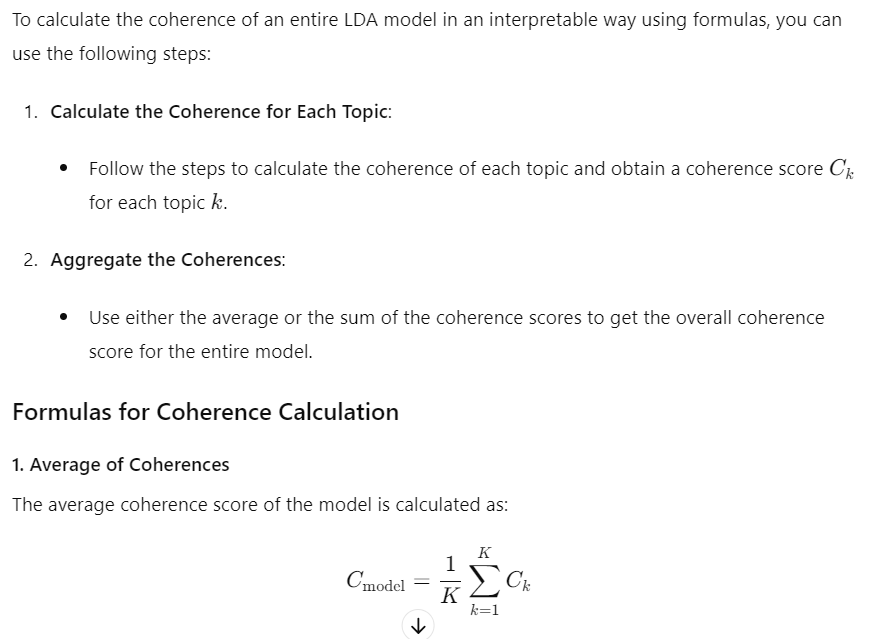

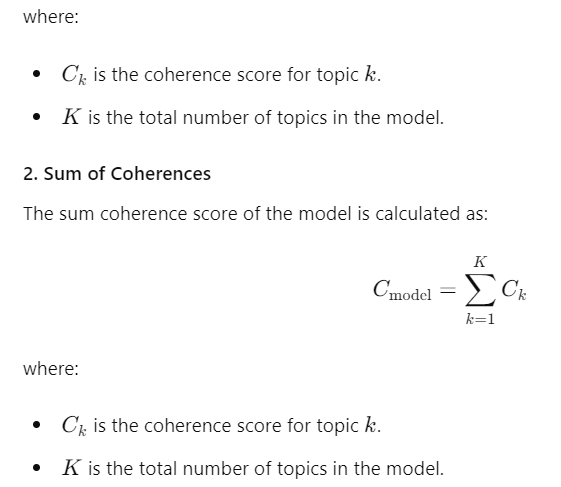

In [17]:
class Metrics():

  def bert_coherence(self, sentences, topics):

    # Preprocess Documents
    documents = pd.DataFrame({
        "Document": sentences[0:10000],
        "ID": range(len(sentences[0:10000])),
        "Topic": topics}
    )
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = BERTopic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = BERTopic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in BERTopic_model.get_topic(topic)] for topic in range(len(set(topics)))]

    # Evaluate
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=tokens,
        corpus=corpus,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    return coherence

  def t2v_coherence(self, sentences, topics):
      tokenized = [list(tokenize(doc)) for doc in sentences]
      id2word = corpora.Dictionary(tokenized)
      corpus = [id2word.doc2bow(text) for text in tokenized]

      # make sure you grab the topic words from the topic model and convert them to a list
      coherence_model = CoherenceModel(
          topics = topics,
          texts=tokenized,
          corpus=corpus,
          dictionary=id2word,
          coherence='c_v',
          topn=10
      )
      coherence = coherence_model.get_coherence()
      return coherence

class AllWordClouds():

    def lda_wordcloud(self, topic, lda_model):
        wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
        texts = [x[0] for x in lda_model.show_topic(topic)]
        long_string = ','.join(texts)
        wordcloud.generate(long_string)

        return wordcloud.to_image()


### **Data table formatter**
Enable colab `data_table`.

In [18]:
from google.colab import data_table
#data_table.enable_dataframe_formatter()        # in case you want to format output tables

<hr>

## **Data**
In this section, we will download, import and preprocess the data needed for the analysis.

### **Data Download**
Download the data. If `from_colab` is set to `True`, this cell will automatically clone the repository into the colab environment. The repository contains data and useful resources.

In [19]:
if from_colab:
    if Path("/content/TopicModelingLab").is_dir():
        %cd "/content/TopicModelingLab"
        !git pull
    else:
        %cd "/content"
        !git clone https://github.com/istat-methodology/TopicModelingLab.git
    path = '/content/TopicModelingLab/dataset'
else:
    path = 'dataset'

/content/TopicModelingLab
Already up to date.


### **Data Import**
After the data is downloaded, we need to import it as a `pd.DataFrame`.

In [20]:
tutorial_dataset  = pd.read_csv(f"{path}/tutorial_dataset_covid_100k.csv")
tutorial_dataset.head()

date                                               text
0  2020-05-08  mi può spiegare cosa c entra un bonus fatto pe...
1  2020-02-14  la commissione dice che il reddito di cittadin...
2  2020-05-14                jeperego per far girare l economia 
3  2020-03-29  questi sono gli economisti per cui siccome la ...
4  2020-05-16  urgente una mia compagna di scuola deve fare u...

Check the shape of the data frame.

In [21]:
tutorial_dataset.shape

(100000, 2)

Plot the Tweet volume distribution over time.

In [22]:
tweet_counts = tutorial_dataset.groupby('date').count().reset_index()

fig = px.line(tweet_counts, x='date', y='text', title="Tweet Distribution over the Time Range", labels={'date': 'Date', 'text': 'N Tweets'})
fig.update_layout(xaxis=dict(tickangle=45))

fig.show()

### **Data Pre-processing**

#### **General pre-processing**
Extract a sample of sentences from the dataframe. In order to run the tutorial scripts in real time we limit our analysis to `limit_dataset` (10,000) sentences

In [23]:
if limit_dataset is not None:
  sentences = [text for text in tutorial_dataset.sample(limit_dataset, random_state=seed).text]
else:
  sentences = [text for text in tutorial_dataset.text]

print(f"N. of sentences: {len(sentences)}")

N. of sentences: 10000


Every sentence corresponds to a Tweet. We can inspect the individual Tweets by indexing the `sentences` list. For example, here is the 166th Tweet in the list:

In [24]:
print(sentences[165])

mastrotitta quelli per cui l unico consumo ammissibile in questo momento così difficile sarebbe quello di pane e acqua quegli stessi che poi si lamentano della disoccupazione generata dal crollo dei consumi 


#### **Pre-processing for Traditional Methods**
Before training our models, we need to pre-process the data to make it suitable for analysis.

##### **Stop words initialization**

In [25]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('italian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Visualize some of the stopwords.

In [26]:
print(list(stop_words)[0:19])

['sta', 'stavamo', 'mie', 'avrà', 'avuta', 'saranno', 'staresti', 'stavate', 'stettero', 'ai', 'tuo', 'alla', 'hanno', 'cui', 'aveste', 'fecero', 'hai', 'vostro', 'sarebbe']


##### **Tokenization and stopwords removal**
In order for the texts to be processed by the algorithms, we need to tokenize them, i.e. turning strings into indices. We will also remove stopwords (like articles and words that do not impact a sentence's meaning) in order to obtain clean topics.

In [27]:
clean_sentences = []

for document in sentences:
    tokens = word_tokenize(document)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]
    clean_sentences.append(filtered_tokens)

Visualize a Tweet before and after cleaning:

In [28]:
tweet_idx = 25

print(f'Original Text:\n{sentences[tweet_idx]}\n')
print(f'Clean Text:\n{clean_sentences[tweet_idx]}')

Original Text:
debito e fiducia il difficile rapporto tra la cicala italiana e le formica tedesca di albertobisin micheleboldrin bruscosandro clementi gl andreamoro e giulio zanella [] 

Clean Text:
['debito', 'fiducia', 'difficile', 'rapporto', 'cicala', 'italiana', 'formica', 'tedesca', 'albertobisin', 'micheleboldrin', 'bruscosandro', 'clementi', 'gl', 'andreamoro', 'giulio', 'zanella']


##### **Bag-Of-Words (BOW) via Gensim: construction of dictionary and term-document matrix**
Both LDA and HDP work with bag-of-words (BOW), i.e., documents are represented in a way in which the order of words does not matter. The dictionary (or vocabulary) represents the set of unique words in the corpus.



In [29]:
dictionary = corpora.Dictionary(clean_sentences)
corpus_bow = [dictionary.doc2bow(t) for t in clean_sentences]

Explore the dictionary object.

In [30]:
type(dictionary)

gensim.corpora.dictionary.Dictionary

We can access the dictionary to obtain the token relative to a specific word.

In [31]:
dictionary.token2id['giovani']

169

Compare to the original text to the clean text and the tokenized text.

In [32]:
tweet_idx = 1200

print(f'Original Text:\n{sentences[tweet_idx]}\n')
print(f'Clean Text:\n{clean_sentences[tweet_idx]}\n')
print(f'Tokenized Text:\n{corpus_bow[tweet_idx]}')

Original Text:
banche centrali in azione mercati nel panico [] 

Clean Text:
['banche', 'centrali', 'azione', 'mercati', 'panico']

Tokenized Text:
[(12, 1), (148, 1), (1063, 1), (2742, 1), (8158, 1)]


<hr>

## **A. Traditional Topic Modeling Algorithms**
In this section, we will explore traditional topic modeling algorithms such as Latent Dirichlet Allocation (LDA), Hierarchical Dirichlet Process (HDP), and Non-negative Matrix Factorization (NMF).

### **Latent Dirichlet Allocation (LDA)**

In [33]:
from gensim.models import LdaModel

Latent Dirichlet Allocation (LDA) is a generative probabilistic model that assumes documents to be mixtures of topics, and topics to be mixtures of words.

LDA involves the following steps:
1. **Parameter Initialization**: LDA initializes the topics, the topic distribution for each document, and the word distribution for each topic.
2. **Training**: Using an iterative process (usually Gibbs sampling or variational inference), LDA refines these distributions to better fit the observed data.
3. **Topic Inference**: After several iterations, LDA infers the topic distribution for each document and the word distribution for each topic.

In LDA, the number of latent topics to be extracted needs to be defined *a priori*.

#### **Model training**
To train an LDA model, we need to specify *a priori* the number of latent topics we want to extract using the `num_topics` argument in gensim's `LdaModel` class. The `gensim` library also contains a `LdaMulticore` class for faster processing.

In [34]:
passes = 10
num_topics = 20

lda_model = LdaModel(
    corpus=corpus_bow,
    id2word=dictionary,
    passes=passes,
    num_topics=num_topics,
    random_state=seed
)

#### **Topic visualization**
Visualize the extracted topics using the `print_topics()` method.

In [35]:
for idx, topic in lda_model.print_topics():
    print(f"Topic: {idx} \nWords: {topic}\n")

Topic: 0 
Words: 0.012*"coronavirus" + 0.011*"costi" + 0.009*"oggi" + 0.009*"borsa" + 0.009*"economia" + 0.008*"covid" + 0.008*"vuole" + 0.007*"news" + 0.007*"italiani" + 0.007*"milano"

Topic: 1 
Words: 0.021*"banche" + 0.021*"economia" + 0.017*"coronavirus" + 0.013*"italia" + 0.012*"covid" + 0.010*"crisi" + 0.010*"economica" + 0.009*"banca" + 0.009*"governo" + 0.009*"emergenza"

Topic: 2 
Words: 0.026*"euro" + 0.017*"mila" + 0.012*"coronavirus" + 0.009*"cassa" + 0.008*"bonus" + 0.008*"s" + 0.008*"famiglie" + 0.007*"m" + 0.007*"emergenza" + 0.007*"covid"

Topic: 3 
Words: 0.053*"debito" + 0.023*"mes" + 0.017*"pubblico" + 0.013*"ue" + 0.012*"solo" + 0.010*"fare" + 0.009*"italia" + 0.008*"cosa" + 0.008*"bce" + 0.008*"italiani"

Topic: 4 
Words: 0.013*"risparmi" + 0.011*"mes" + 0.009*"italia" + 0.009*"francia" + 0.009*"cittadini" + 0.008*"tanti" + 0.008*"germania" + 0.008*"notizia" + 0.008*"tedeschi" + 0.007*"scuole"

Topic: 5 
Words: 0.020*"economia" + 0.011*"vendite" + 0.010*"stipendio

To visualize the topics extracted by the LDA, we can plot some *wordclouds*.

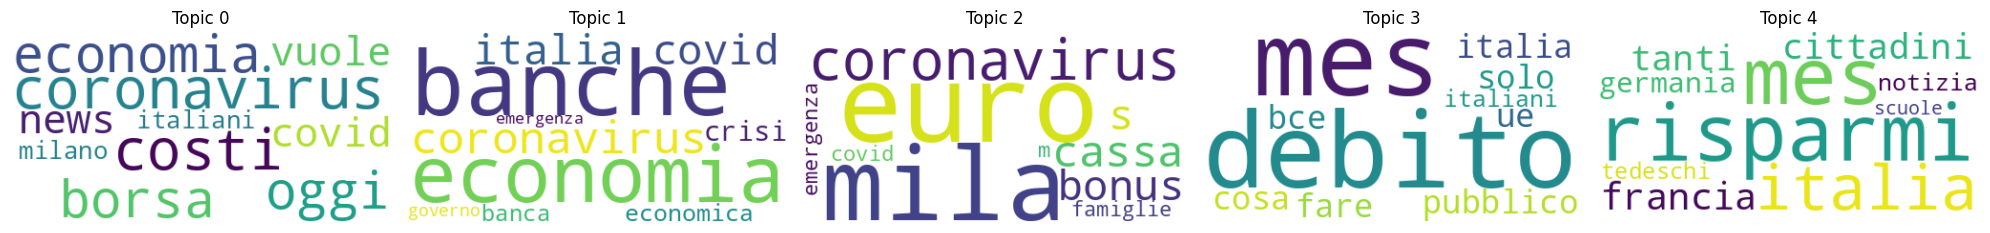

In [36]:
N = 5

wc_lda = AllWordClouds()

fig, axes = plt.subplots(1, N, figsize=(20, 4))

for i in range(N):
    wc = wc_lda.lda_wordcloud(i, lda_model)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Topic {i}')

plt.tight_layout()
plt.show()

#### **Model coherence**

In [37]:
coherence_model = CoherenceModel(model=lda_model, texts=clean_sentences, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print("LDA Model Coherence: ", round(coherence_score, 5))

LDA Model Coherence:  0.35332


<hr>

### **Hierarchical Dirichlet Process (HDP)**

In [38]:
from gensim.models import HdpModel

Hierarchical Dirichlet Process (HDP) is a non-parametric Bayesian approach to topic modeling. Unlike LDA, HDP automatically determines the number of topics based on the data.

HDP involves the following steps:
1. **Initialization**: HDP starts with an initial guess on the topic distribution.
2. **Iterative Refinement**: Using a hierarchical process, HDP refines the topic distribution at both the document and corpus levels.
3. **Dynamic Topic Adjustment**: HDP adjusts the number of topics dynamically as more data is processed.


####**Model training**
Differently from LDA, in HDP we do not need to specify the number of topics to extract *a priori*. By default, `HdpModel` will always produce 150 topics (unless you change the argument `T`) and order them by importance, measured by the `alpha` parameter.

In [39]:
hdp_model = HdpModel(
    corpus=corpus_bow,
    id2word=dictionary,
    random_state=seed
)

#### **Topic visualization**
Visualize the extracted topics using the `print_topics()` method. Visualize the first 30 topics for convenience.

In [40]:
for idx, topic in hdp_model.print_topics(num_topics=30):
    print(f"Topic: {idx} \nWords: {topic}\n")

Topic: 0 
Words: 0.006*economia + 0.006*italia + 0.005*lavoro + 0.005*debito + 0.004*tasse + 0.004*senza + 0.004*italiani + 0.004*mes + 0.004*soldi + 0.004*reddito

Topic: 1 
Words: 0.005*economia + 0.004*debito + 0.004*italia + 0.003*euro + 0.003*banche + 0.003*coronavirus + 0.003*ora + 0.003*soldi + 0.003*governo + 0.002*mes

Topic: 2 
Words: 0.003*economia + 0.003*italia + 0.003*tasse + 0.002*senza + 0.002*debito + 0.002*stato + 0.002*lavoro + 0.002*italiani + 0.002*governo + 0.002*euro

Topic: 3 
Words: 0.003*economia + 0.003*spread + 0.003*lagarde + 0.002*italia + 0.002*tasse + 0.002*coronavirus + 0.002*draghi + 0.002*anni + 0.002*crisi + 0.002*solo

Topic: 4 
Words: 0.003*economia + 0.002*tasse + 0.002*italia + 0.002*governo + 0.002*fare + 0.002*poi + 0.002*spese + 0.002*debito + 0.002*stipendio + 0.001*soldi

Topic: 5 
Words: 0.003*economia + 0.002*soldi + 0.002*italia + 0.002*cosa + 0.001*mes + 0.001*lavoro + 0.001*conte + 0.001*ue + 0.001*debito + 0.001*covid

Topic: 6 
Words:

To visualize the topics extracted by the LDA, we can plot some *wordclouds*.

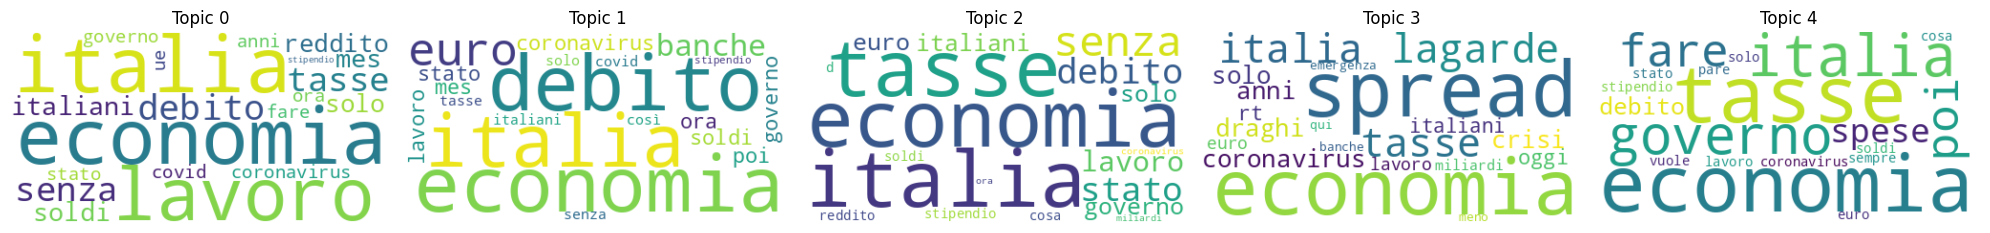

In [41]:
N = 5

wc_hdp = AllWordClouds()

fig, axes = plt.subplots(1, N, figsize=(20, 4))

for i in range(N):
    wc = wc_hdp.lda_wordcloud(i, hdp_model)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Topic {i}')

plt.tight_layout()
plt.show()

#### **Model coherence**

In [42]:
coherence_model = CoherenceModel(model=hdp_model, texts=clean_sentences, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print("HDP Model Coherence: ", round(coherence_score, 5))

HDP Model Coherence:  0.4885


<hr>

### **Non-Negative Matrix Factorization (NMF)**

In [43]:
from gensim.models import Nmf

Non-negative Matrix Factorizzation (NMF) is a non-probabilistic technique, particularly suitable for large, sparse datasets. Unlike probabilistic models like LDA and HDP, NMF is a linear algebra-based method that decomposes the document-term matrix into two lower-dimensional matrices, one representing the topics and the other representing the topic distribution for each document.

NMF involves the following steps:
1. **Matrix Decomposition**: NMF decomposes the document-term matrix into two non-negative matrices.
2. **Iterative Optimization**: Using iterative optimization techniques, NMF refines these matrices to minimize the reconstruction error.
3. **Topic Extraction**: The resulting matrices are used to extract the topics and their distribution across documents.

Likewise LDA, NMF requires the number of topics to extract to be defined *a priori*.

#### **Model training**

In [44]:
num_topics = 20

nmf_model = Nmf(
    corpus=corpus_bow,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=seed
)

#### **Topic visualization**
Visualize the extracted topics using the `print_topics()` method.

In [45]:
for idx, topic in nmf_model.print_topics():
    print(f"Topic: {idx} \nWords: {topic}\n")

Topic: 0 
Words: 0.054*"quando" + 0.020*"coronavirus" + 0.011*"soldi" + 0.010*"solo" + 0.010*"dopo" + 0.006*"acquistare" + 0.006*"famiglie" + 0.005*"spendere" + 0.004*"giorno" + 0.004*"famiglia"

Topic: 1 
Words: 0.050*"governo" + 0.047*"senza" + 0.018*"mes" + 0.011*"covid" + 0.008*"miliardi" + 0.007*"banche" + 0.007*"ue" + 0.007*"condizioni" + 0.006*"ogni" + 0.005*"conte"

Topic: 2 
Words: 0.036*"no" + 0.015*"economia" + 0.013*"vuole" + 0.012*"poi" + 0.011*"banche" + 0.009*"così" + 0.008*"sempre" + 0.008*"spese" + 0.007*"dice" + 0.006*"fatto"

Topic: 3 
Words: 0.027*"s" + 0.026*"tasse" + 0.022*"m" + 0.011*"debito" + 0.010*"prezzi" + 0.009*"rt" + 0.007*"soldi" + 0.007*"niente" + 0.007*"dice" + 0.006*"dopo"

Topic: 4 
Words: 0.121*"italia" + 0.009*"europa" + 0.007*"paese" + 0.007*"covid" + 0.005*"economia" + 0.005*"d" + 0.004*"può" + 0.004*"fa" + 0.003*"germania" + 0.003*"grecia"

Topic: 5 
Words: 0.033*"debito" + 0.032*"anni" + 0.030*"pubblico" + 0.007*"stati" + 0.007*"essere" + 0.006*

To visualize the topics extracted by the LDA, we can plot some *wordclouds*.

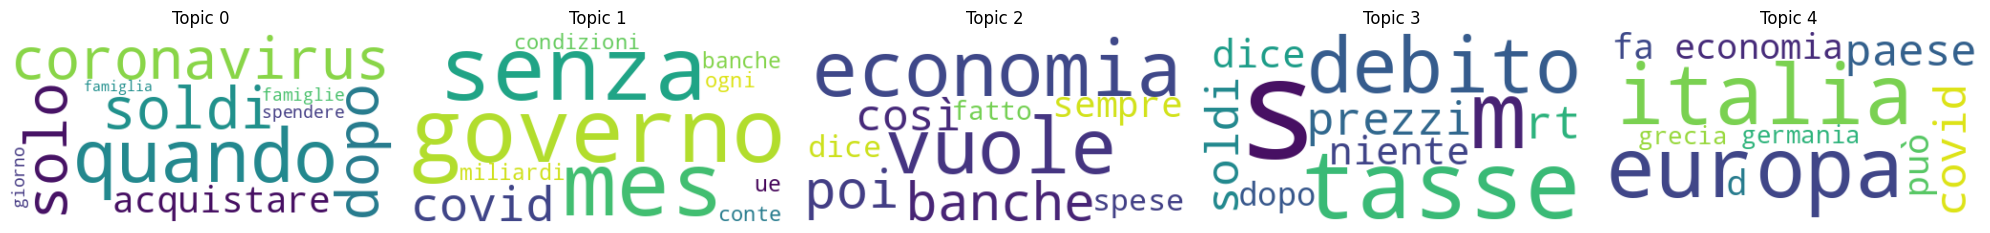

In [46]:
N = 5

wc_nmf = AllWordClouds()

fig, axes = plt.subplots(1, N, figsize=(20, 4))

for i in range(N):
    wc = wc_nmf.lda_wordcloud(i, nmf_model)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Topic {i}')

plt.tight_layout()
plt.show()

#### **Model coherence**

In [47]:
coherence_model = CoherenceModel(model=nmf_model, texts=clean_sentences, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print("NMF Model Metrics (Coherence): ", round(coherence_score, 5))

NMF Model Metrics (Coherence):  0.37441


<hr>

## **B. Clustering Algorithms on Embedding Spaces**
Clustering algorithms on embedding spaces, such as Top2Vec and BERTopic, leverage neural network-based embeddings to discover topics in text data. Unlike traditional topic modeling algorithms like LDA, HDP and NMF, which rely on statistical methods to discover topics in a corpus, these newer approaches use dense vector representations to capture semantic similarities more effectively.

### **Top2Vec**

In [48]:
from top2vec import Top2Vec

Top2Vec (https://github.com/ddangelov/Top2Vec) is an algorithm that simultaneously learns the topic representations and the word embeddings. By mapping documents to a continuous vector space, Top2Vec identifies clusters of documents that share similar themes without requiring a pre-defined number of topics. This approach allows for the discovery of natural and meaningful topics directly from the data.

Top2Vec involves the following steps:
1. **Embedding Creation**: Top2Vec uses word embeddings to create document vectors.
2. **Dimensionality Reduction**: The document vectors are reduced to a lower-dimensional space using techniques like UMAP.
3. **Clustering**: The reduced vectors are clustered to identify topics.
4. **Topic Words Identification**: The algorithm finds words that are closest to the cluster centroids, representing the topics.


**Top2Vec** is an algorithm for extracting and representing topics in a set of documents. It broadly works through the following steps:

**Document Embeddings:** It uses embedding models such as Doc2Vec or Universal Sentence Encoder to transform each document into a dense vector of fixed dimensions. This vector represents the semantic content of the document.

**Dimensionality Reduction:** It applies a dimensionality reduction technique like UMAP (Uniform Manifold Approximation and Projection) to reduce the dimensionality of the document embeddings, facilitating subsequent analysis.

**Clustering:** It uses HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) to identify clusters of similar documents in the reduced space. Each cluster represents a topic.

**Topic Representation:** For each cluster, it calculates an "average embedding" that represents the topic. It finds the words closest to this average embedding in the original embedding space to determine the keywords for the topic.

**Assignment of Documents to Topics:** Each document is assigned to the topic of the nearest cluster in which it is located, based on its representation in the reduced embedding space.

**Dynamic Updates:** The algorithm supports the dynamic updating of topics as new documents are added, without the need to recalculate the entire model from scratch.

#### **Model training**

In [49]:
# choose the embedding model
embeddings = 'distiluse-base-multilingual-cased'

# train the Top2Vec model
min_word_count = 5

t2v_model = Top2Vec(
    documents=sentences,
    embedding_model=embeddings,
    min_count=min_word_count
)

2024-06-27 10:33:14,089 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2024-06-27 10:33:15,070 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
INFO:top2vec:Downloading distiluse-base-multilingual-cased model


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.39k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2024-06-27 10:33:24,847 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-06-27 10:33:43,904 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-06-27 10:34:25,042 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2024-06-27 10:34:25,518 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


#### **Topic visualization**

In [50]:
topics = t2v_model.get_topics()

words_list = topics[0]
scores_list = topics[1]
topic_num_list = topics[2]
topic_size_list, _ = t2v_model.get_topic_sizes()

print(f'Top2Vec extracted {t2v_model.get_num_topics()} topics.\n')

for words, scores, topic_num in zip(words_list, scores_list, topic_num_list):
    df_vis = pd.DataFrame({'word': words, 'score': scores})
    topic_size = topic_size_list[topic_num]
    print(f'Topic {topic_num} ({topic_size} Tweets):')
    print(df_vis.head(10), '\n')

Top2Vec extracted 7 topics.

Topic 0 (8589 Tweets):
             word     score
0      economista  0.274897
1          brexit  0.266155
2        economie  0.265860
3      economisti  0.262488
4       economist  0.259914
5        economia  0.259520
6         fiscale  0.256623
7       econopoly  0.251947
8  macroeconomico  0.241379
9       economici  0.240869 

Topic 1 (391 Tweets):
              word     score
0        eurogroup  0.376375
1       eurogruppo  0.375062
2         eurozona  0.341273
3         eurobond  0.326101
4        eurobonds  0.324912
5  gualtierieurope  0.308085
6          europea  0.307218
7          europei  0.304549
8        economist  0.303782
9         european  0.303446 

Topic 2 (278 Tweets):
              word     score
0          polizia  0.306775
1  politicaperjedi  0.266639
2         politici  0.260566
3      carabinieri  0.259664
4         protesta  0.224866
5            mafia  0.223677
6          mafiosi  0.218441
7    politicamente  0.212101
8         po

To visualize the topics extracted by the LDA, we can plot some *wordclouds*.

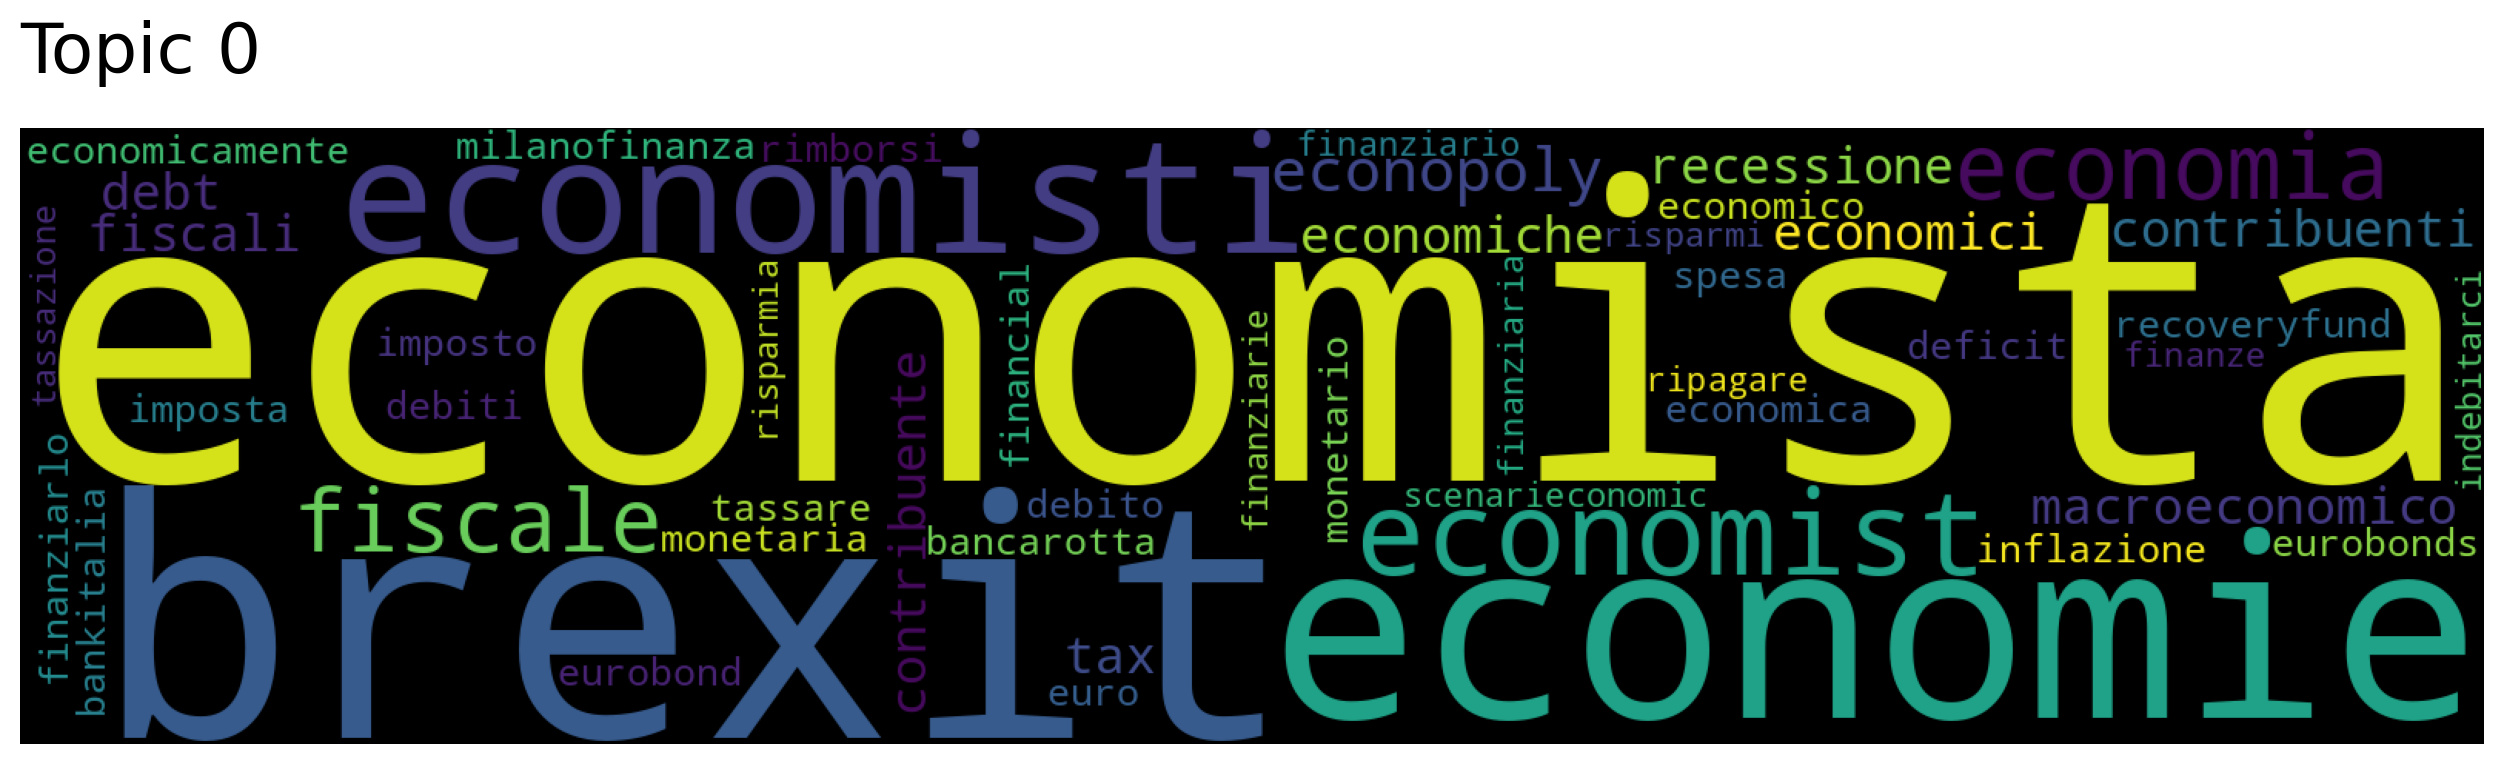

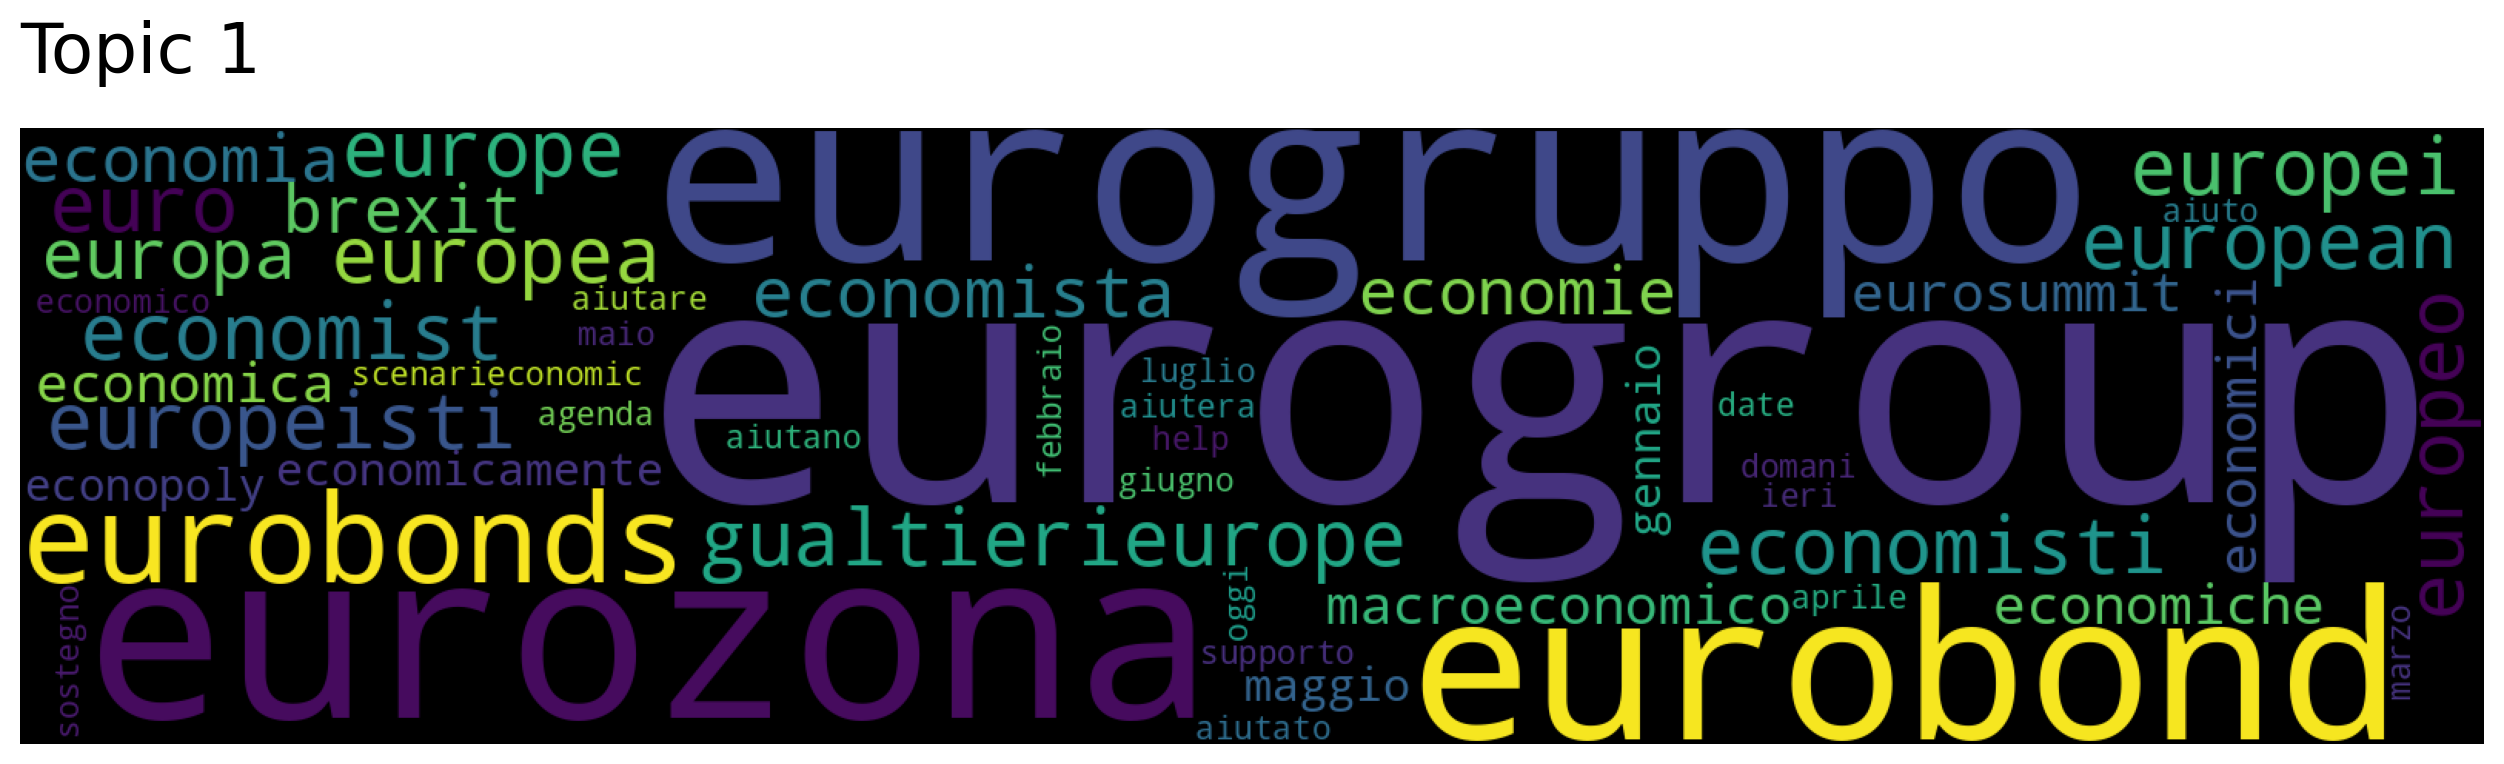

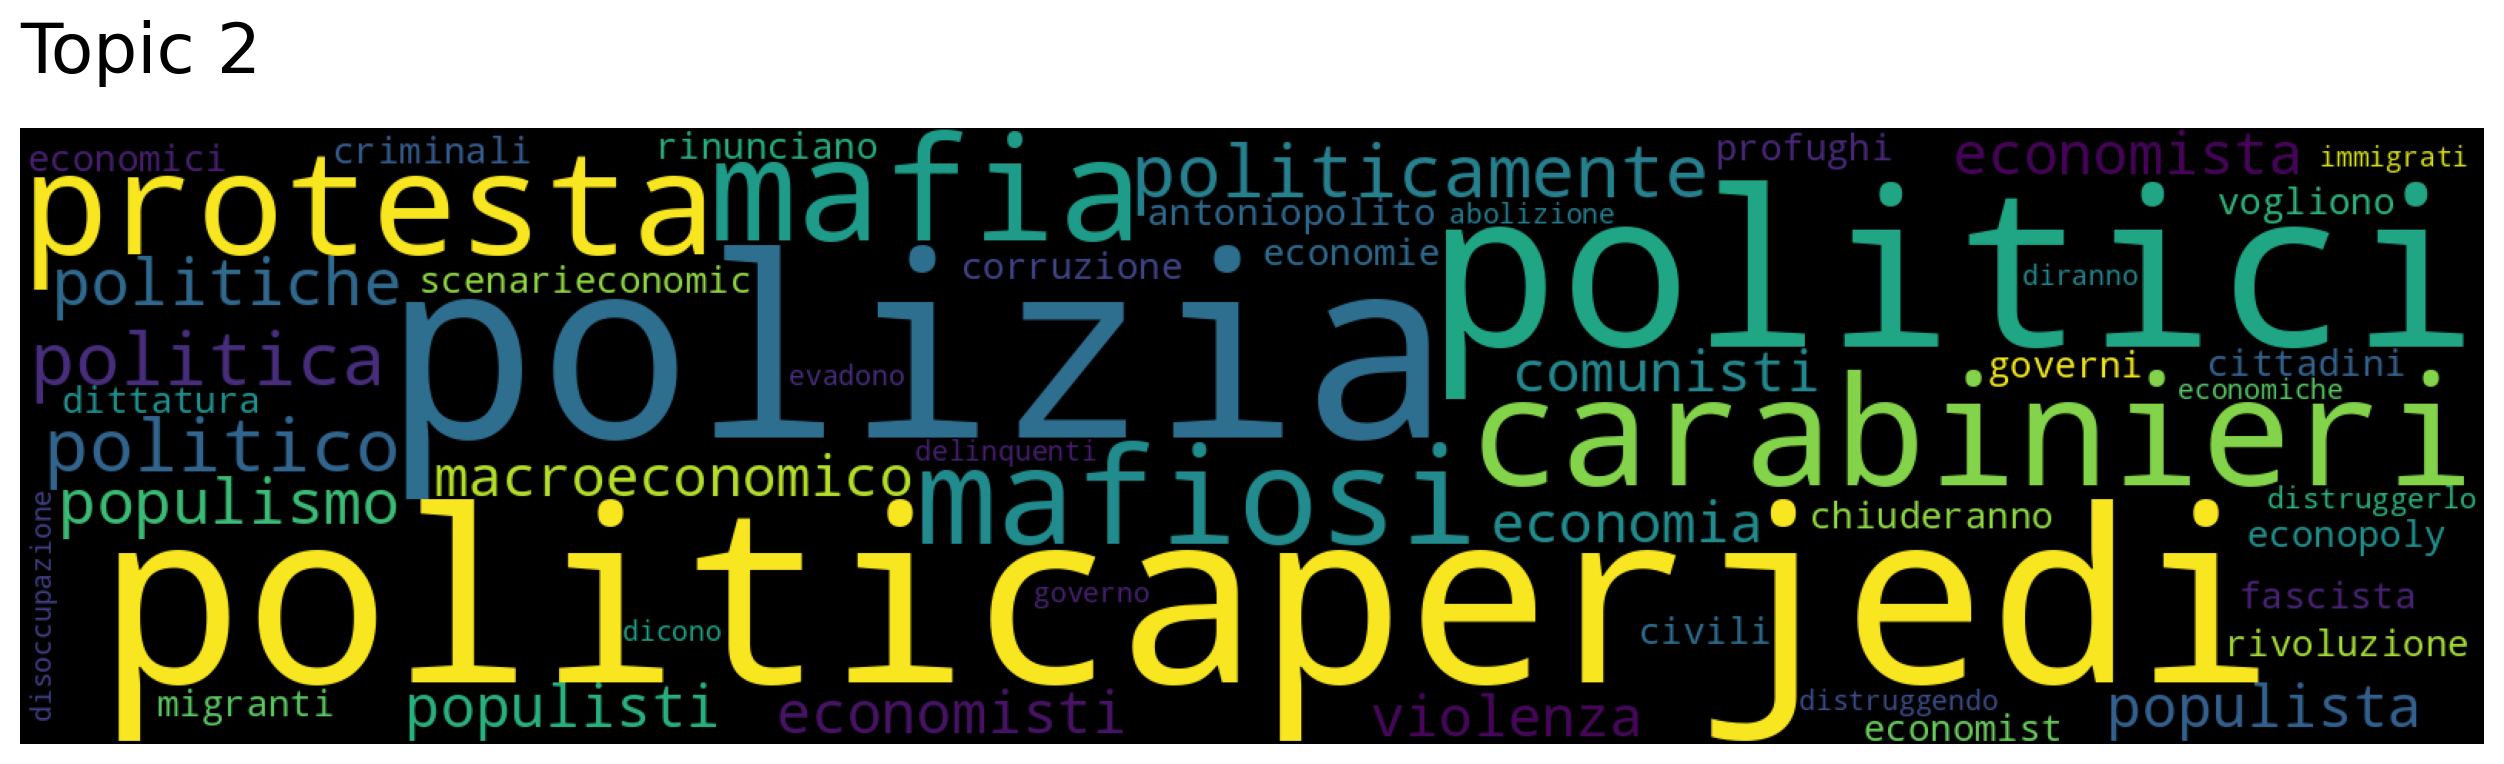

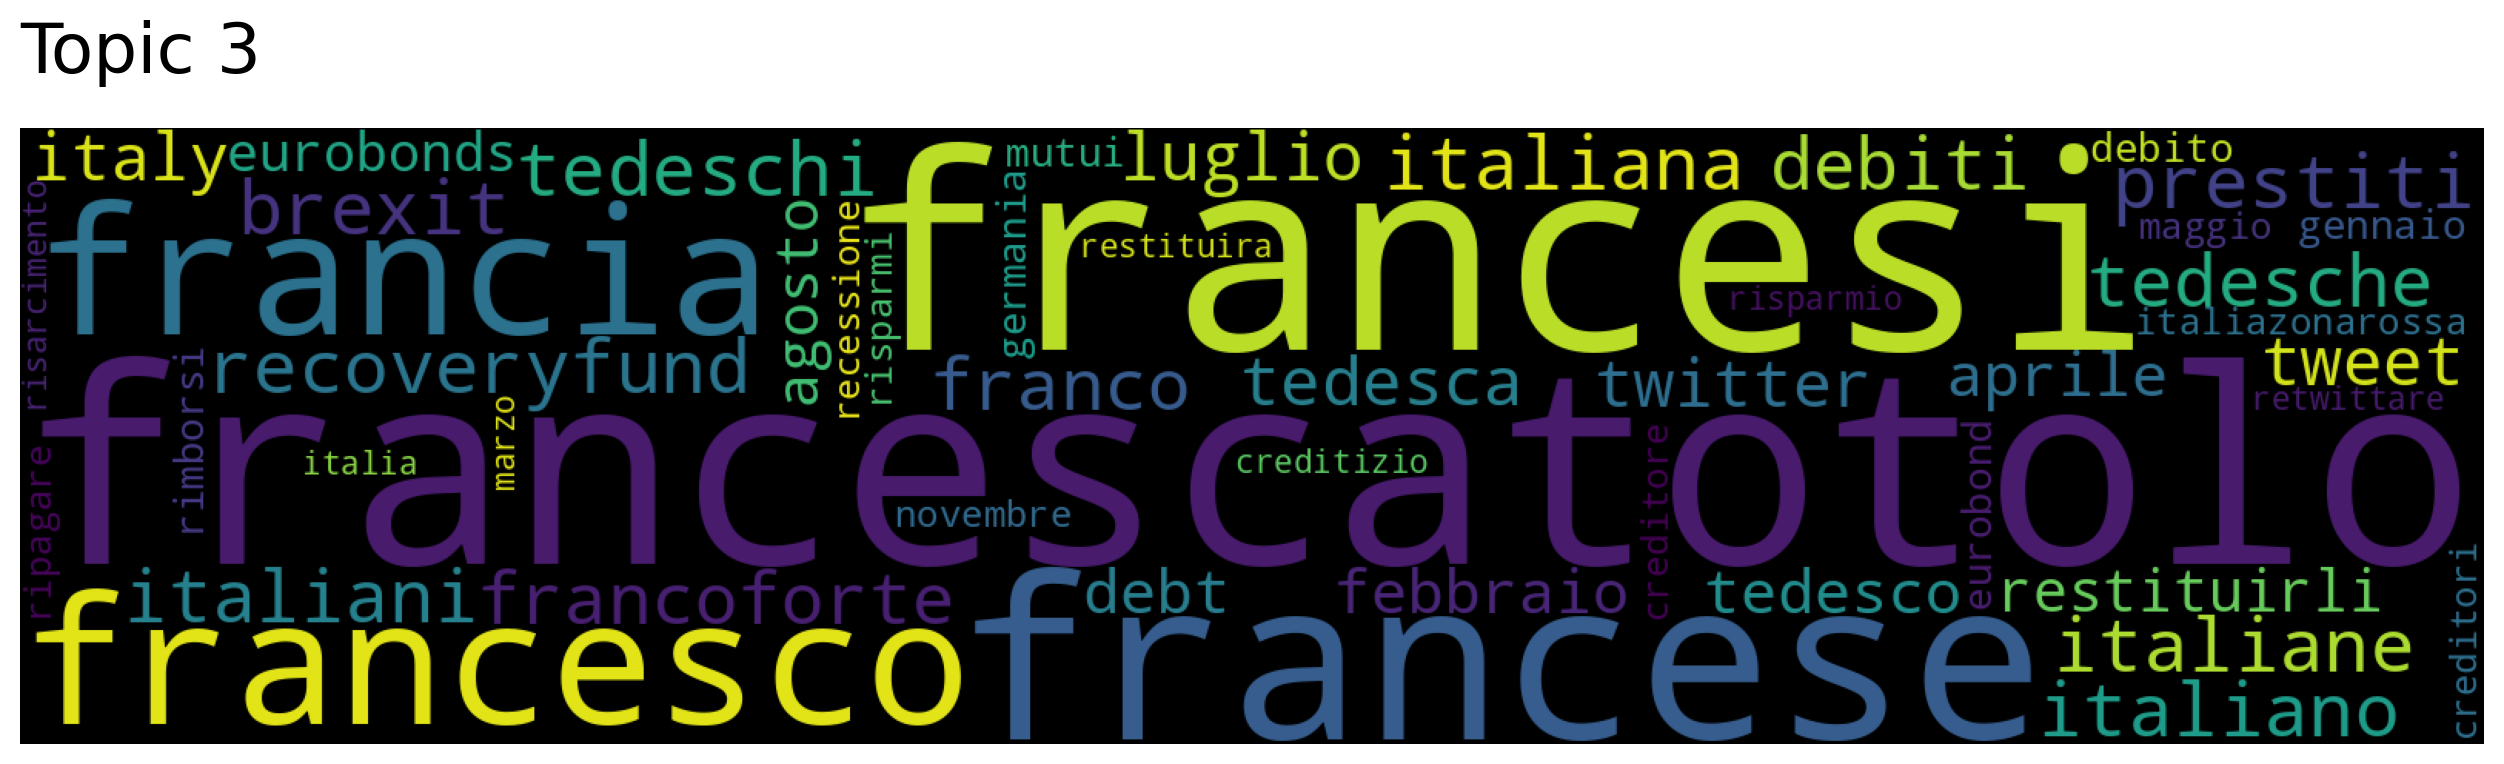

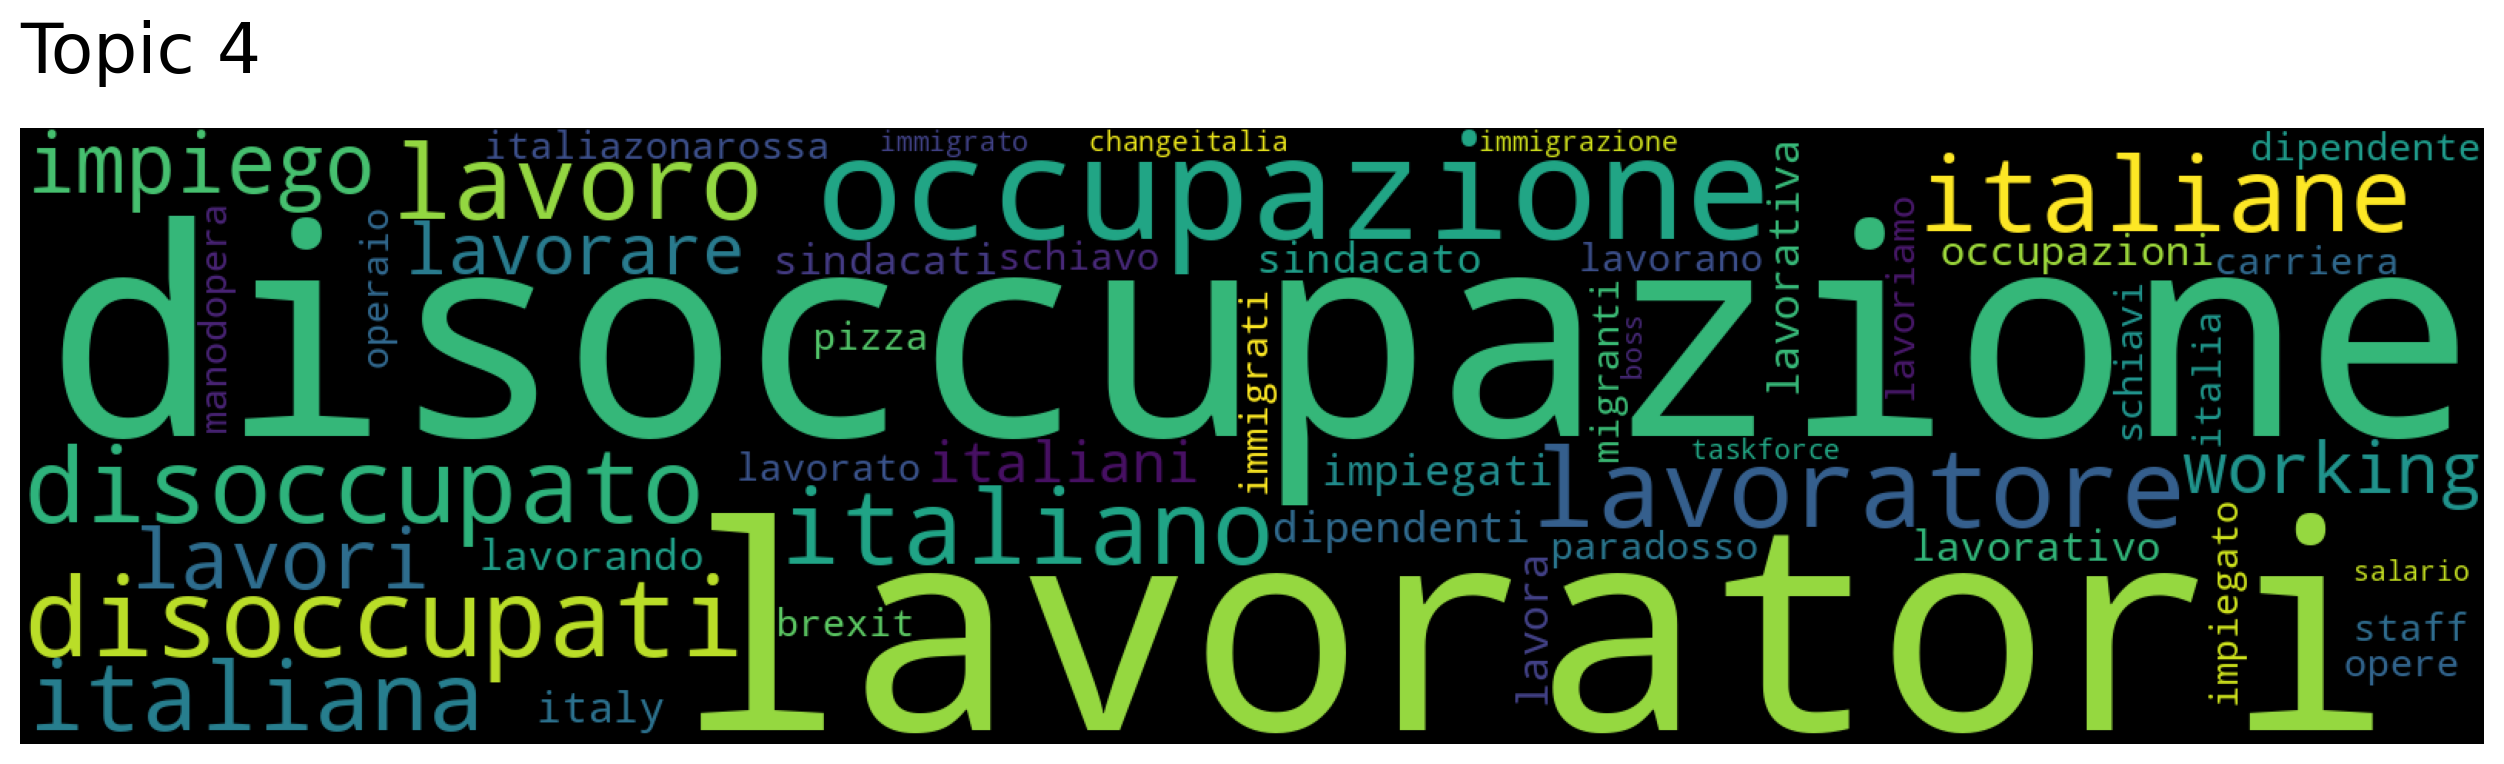

In [51]:
for topic in range(5):
    t2v_model.generate_topic_wordcloud(topic)

#### **Model coherence**

In [52]:
metrics = Metrics()
t2v_coherence = metrics.t2v_coherence(sentences, t2v_model.get_topics()[0])

print("Top2Vec Model Coherence: ", round(t2v_coherence, 5))

Top2Vec Model Coherence:  0.39879


<hr>

### **BERTopic**

In [53]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from torch import bfloat16
import transformers
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

BERTopic leverages transformer-based embeddings to create document representations and applies clustering algorithms to discover topics. It combines BERT embeddings with clustering techniques like HDBSCAN and dimensionality reduction methods like UMAP to generate coherent topics from text data.

BERTopic involves the following steps:
1. **Embedding Creation**: BERTopic uses transformer models to create document embeddings.
2. **Dimensionality Reduction**: The embeddings are reduced in dimensionality using UMAP.
3. **Clustering**: Density-based clustering algorithm such as HDBSCAN are applied to form clusters from the reduced embeddings.
4. **Topic Representation**: The algorithm generates topics based on the clustered documents and their embeddings. In this step, LLMs can be used for automatic and meaningful topic labeling.

For more detailed information and examples, you can visit the [BERTopic documentation](https://maartengr.github.io/BERTopic).


The BERTopic repository is always up-to-date; recently, they have greatly enhanced support for LLM (Llama2, Llama3, ChatGPT 3.5 Turbo) for topic representation.

https://github.com/MaartenGr/BERTopic

#### **Model training (K-free)**
Let's start by training a K-free BERTopic model, i.e. we don't specify the number of topics we want to obtain. To prevent BERTopic from extracting too many topics, we can impose a condition on the minimum number of documents (Tweets) that a topic should include through the `min_topic_size` argument.

In [54]:
# import the embedding_model
embeddings = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# train the BERTopic model
min_topic_size = 30

BERTopic_model = BERTopic(
    embedding_model=embeddings,
    min_topic_size=min_topic_size,
    verbose=True
)
topics, probs = BERTopic_model.fit_transform(sentences)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-06-27 10:34:44,090 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2024-06-27 10:34:54,900 - BERTopic - Embedding - Completed ✓
2024-06-27 10:34:54,902 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-27 10:35:19,672 - BERTopic - Dimensionality - Completed ✓
2024-06-27 10:35:19,678 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-27 10:35:20,693 - BERTopic - Cluster - Completed ✓
2024-06-27 10:35:20,706 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-27 10:35:21,490 - BERTopic - Representation - Completed ✓


#### **Topic visualization (K-free)**
The topic labeled as `-1` is a residual topic of documents BERTopic was not able to classify.

In [55]:
BERTopic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1   3513                                    -1_di_che_il_la   
1       0   1651                            0_italia_italiani_di_in   
2       1   1106                         1_coronavirus_per_virus_il   
3       2    805                             2_debito_banche_il_che   
4       3    255                              3_sanità_medici_di_le   
5       4    254                              4_tasse_le_pagare_che   
6       5    237                         5_prezzi_vendite_online_di   
7       6    236                          6_germania_la_tedeschi_di   
8       7    226                       7_cittadinanza_reddito_di_il   
9       8    213                                8_economia_di_un_la   
10      9    193                       9_eurobond_debito_europa_mes   
11     10    113                            10_stipendio_lo_non_che   
12     11     92                    11_disoccupazione_lavoro_di_non   
13     12     82                  12_nero_migranti_immigrati_lavoro   
14     13     82                13_calcio_club_calciatori_giocatori   
15     14     80                       14_scuole_famiglie_le_scuola   
16     15     79                        15_euro_mese_stipendio_lega   
17     16     74         16_courtesyas_ministro_ritwittate_drastico   
18     17     67                              17_chi_la_papa_chiesa   
19     18     63                  18_mascherine_prezzi_prezzo_delle   
20     19     63                      19_mi_ho_spendere_risparmiare   
21     20     56           20_inflazione_moneta_stampare_deflazione   
22     21     49                             21_media_che_le_nessun   
23     22     43  22_finanziamenti_finanziamento_fondazioni_spaz...   
24     23     43                         23_turismo_il_economia_del   
25     24     41                  24_parlamentari_stipendio_un_loro   
26     25     39                            25_euro_costi_moneta_se   
27     26     38          26_green_ambientale_ecobonus_investimenti   
28     27     38           27_terroristi_riscatto_occupazione_jihad   
29     28     36                      28_donne_femminile_uomini_più   
30     29     36                 29_giappone_stimoli_dollari_chissà   
31     30     34                     30_povertà_mondo_la_invisibile   
32     31     32        31_diegorusso_pbiagiola_elia_scacciavillani   
33     32     31               32_giustizia_governo_un_prescrizione   

                                       Representation  \
0         [di, che, il, la, non, per, in, un, le, si]   
1   [italia, italiani, di, in, il, che, per, la, n...   
2   [coronavirus, per, virus, il, di, la, in, del,...   
3   [debito, banche, il, che, di, non, le, la, per...   
4   [sanità, medici, di, le, ospedali, sanitarie, ...   
5   [tasse, le, pagare, che, non, chi, come, delle...   
6   [prezzi, vendite, online, di, su, amazon, per,...   
7   [germania, la, tedeschi, di, debito, tedesca, ...   
8   [cittadinanza, reddito, di, il, che, per, non,...   
9   [economia, di, un, la, non, in, che, dell, il,...   
10  [eurobond, debito, europa, mes, di, bce, che, ...   
11  [stipendio, lo, non, che, di, se, il, mi, del,...   
12  [disoccupazione, lavoro, di, non, che, la, il,...   
13  [nero, migranti, immigrati, lavoro, chi, regol...   
14  [calcio, club, calciatori, giocatori, asroma, ...   
15  [scuole, famiglie, le, scuola, insegnanti, di,...   
16  [euro, mese, stipendio, lega, al, bonus, lo, d...   
17  [courtesyas, ministro, ritwittate, drastico, p...   
18  [chi, la, papa, chiesa, vita, nella, un, non, ...   
19  [mascherine, prezzi, prezzo, delle, le, masche...   
20  [mi, ho, spendere, risparmiare, se, non, mia, ...   
21  [inflazione, moneta, stampare, deflazione, lir...   
22  [media, che, le, nessun, dei, un, giornalista,...   
23  [finanziamenti, finanziamento, fondazioni, spa...   
24  [turismo, il, economia, del, settore, un, turi...   
25  [parlamentari, stipendio, un, lo

BERTopic also includes hierarchical clustering.

In [56]:
hierarchical_topics = BERTopic_model.hierarchical_topics(sentences)
BERTopic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 32/32 [00:00<00:00, 64.48it/s]


#### **Model training (fixed K)**
We can force BERTopic to extract K Topics by setting an external Clustering Model.

In [57]:
cluster_model = KMeans(n_clusters=20)

umap = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    low_memory=False,
    random_state=seed
)

BERTopic_model = BERTopic(
    embedding_model=embeddings,
    umap_model=umap,
    min_topic_size=30,
    hdbscan_model=cluster_model,
    verbose=True
)
topics, probs = BERTopic_model.fit_transform(sentences)

2024-06-27 10:35:23,161 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2024-06-27 10:35:40,457 - BERTopic - Embedding - Completed ✓
2024-06-27 10:35:40,462 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-27 10:36:12,496 - BERTopic - Dimensionality - Completed ✓
2024-06-27 10:36:12,499 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-27 10:36:12,863 - BERTopic - Cluster - Completed ✓
2024-06-27 10:36:12,871 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-27 10:36:13,173 - BERTopic - Representation - Completed ✓


#### **Topic visualization (fixed K)**

In [58]:
BERTopic_model.get_topic_info()

Topic  Count                                           Name  \
0       0   1176                                0_di_non_che_la   
1       1   1161                        1_italia_italiani_di_in   
2       2   1076                        2_coronavirus_per_il_di   
3       3   1053                          3_debito_banche_il_di   
4       4    973                               4_tasse_di_le_il   
5       5    962                           5_economia_di_che_un   
6       6    793                            6_prezzi_di_che_per   
7       7    639                             7_di_la_che_europa   
8       8    525                          8_italia_debito_di_in   
9       9    415                             9_di_per_la_sanità   
10     10    388                           10_germania_la_di_il   
11     11    387                  11_cittadinanza_reddito_di_il   
12     12    286                                12_di_la_il_per   
13     13     46             13_courtesyas_ministro_rt_economia   
14     14     32    14_diegorusso_scacciavillani_pbiagiola_elia   
15     15     26     15_ritwittate_drastico_prioritario_guidata   
16     16     20     16_ricevesse_autorizzate_circola_circolate   
17     17     19              17_rosso_all_allarme_approvazione   
18     18     13                 18_diego_morto_aveva_svolgendo   
19     19     10  19_più_civilissima_democraticissima_rarissimo   

                                       Representation  \
0   [di, non, che, la, lavoro, il, un, stipendio, ...   
1   [italia, italiani, di, in, che, il, per, la, n...   
2   [coronavirus, per, il, di, la, virus, in, del,...   
3   [debito, banche, il, di, che, non, le, la, per...   
4      [tasse, di, le, il, non, che, per, la, un, in]   
5   [economia, di, che, un, la, non, il, per, in, le]   
6   [prezzi, di, che, per, in, non, vendite, la, i...   
7   [di, la, che, europa, per, euro, il, non, in, un]   
8   [italia, debito, di, in, il, che, la, italiani...   
9   [di, per, la, sanità, le, che, non, emergenza,...   
10  [germania, la, di, il, che, tedeschi, in, per,...   
11  [cittadinanza, reddito, di, il, lavoro, che, p...   
12       [di, la, il, per, in, che, non, un, del, da]   
13  [courtesyas, ministro, rt, economia, da, suona...   
14  [diegorusso, scacciavillani, pbiagiola, elia, ...   
15  [ritwittate, drastico, prioritario, guidata, t...   
16  [ricevesse, autorizzate, circola, circolate, c...   
17  [rosso, all, allarme, approvazione, diffondere...   
18  [diego, morto, aveva, svolgendo, anziano, chia...   
19  [più, civilissima, democraticissima, rarissimo...   

                                  Representative_Docs  
0   [da leggere con attenzione sono un infermiera ...  
1   [salvini è incredibile che domani ci siano mil...  
2   [[] perché il governo non valuta di coinvolger...  
3   [tutte le agenzie di stampa autorevoli ci stan...  
4   [graziano delrio e il decreto fatto dal govern...  
5   [finalmente qualcuno ha fatto a borghi la doma...  
6   [oggi bce manda il povero philip lane a fare m...  
7   [la solidarietà europea in azione eu commissio...  
8   [ci sono voluti morti di cui italiani per amme...  
9   [spero che l esempio di infermieri medici e pe...  
10  [la germania ha comprato tutti gli aeroporti d...  
11  [davidealgebris chiediamo alle aziende agricol...  
12  [il capo di un partito che ha rubato milioni c...  
13  [rt courtesyas ministro da economia [] , rt co...  
14  [gianni elia usugo difesanimzo sandogat thecio...  
15  [auguri alla taskforce guidata da colao per la...  
16  [la bufala del giorno riguarda il mes circola ...  
17  [allarme rosso all eurogruppo invece degli aiu...  
18  [è morto a bergamo un operatore del aveva anni...  
19  [nella civilissima e democraticissima svezia d...

#### **Model coherence (fixed K)**

In [59]:
metrics = Metrics()
bert_coherence = metrics.bert_coherence(sentences, topics)

print("BERTopic Model Metrics (Coherence): ", round(bert_coherence, 5))

BERTopic Model Metrics (Coherence):  0.51247


**NOTE!** if you run under the recommended number of cluster of the original Bert Topic, the coherence will usually decrease!

#### **Topics reduction**
After fitting a BERTopic model, we can reduce the number of topics to a desired K.

In [60]:
BERTopic_model.reduce_topics(sentences, nr_topics=10)

2024-06-27 10:36:26,791 - BERTopic - Topic reduction - Reducing number of topics
2024-06-27 10:36:27,407 - BERTopic - Topic reduction - Reduced number of topics from 20 to 10


Visualize the reduced number of topics

In [61]:
BERTopic_model.get_topic_info()

Topic  Count                                        Name  \
0      0   4966                             0_di_che_il_non   
1      1   3019                              1_di_la_il_che   
2      2   1076                     2_coronavirus_di_il_per   
3      3    793                         3_prezzi_di_che_per   
4      4     46           4_courtesyas_ministro_rt_economia   
5      5     32  5_diegorusso_scacciavillani_pbiagiola_elia   
6      6     26   6_ritwittate_drastico_prioritario_guidata   
7      7     19            7_all_rosso_allarme_approvazione   
8      8     13               8_diego_morto_aveva_svolgendo   
9      9     10         9_più_ha_democraticissima_rarissimo   

                                      Representation  \
0        [di, che, il, non, la, per, le, un, in, ma]   
1   [di, la, il, che, per, in, italia, non, un, del]   
2  [coronavirus, di, il, per, la, in, del, che, v...   
3    [prezzi, di, che, per, in, non, la, il, un, le]   
4  [courtesyas, ministro, rt, economia, da, suona...   
5  [diegorusso, scacciavillani, pbiagiola, elia, ...   
6  [ritwittate, drastico, prioritario, guidata, t...   
7  [all, rosso, allarme, approvazione, diffondere...   
8  [diego, morto, aveva, svolgendo, anziano, chia...   
9  [più, ha, democraticissima, rarissimo, civilis...   

                                 Representative_Docs  
0  [tutte le agenzie di stampa autorevoli ci stan...  
1  [ci sono voluti morti di cui italiani per amme...  
2  [io posso capire assolutamente il fatto che no...  
3  [questo e il motivo per cui ha pienamente sens...  
4  [rt courtesyas ministro da economia [] , rt co...  
5  [gianni elia usugo difesanimzo sandogat thecio...  
6  [auguri alla taskforce guidata da colao per la...  
7  [allarme rosso all eurogruppo invece degli aiu...  
8  [è morto a bergamo un operatore del aveva anni...  
9  [nella civilissima e democraticissima svezia d...

#### **Adding LLaMA-3 for topic labelling**
In order to run this part of the tutorial, you need to be running on a GPU compute (in colab, select **T4 GPU** as a runtime).

##### **Import LLaMA**
First of all, we need to import the `LLaMA-3-8B-Instruct` model and the relative tokenizer from huggingface 🤗. We will use a 4-bit quantized version of the model to improve efficiency.

In [62]:
import accelerate

# Quantization to load an LLM with less GPU memory
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = 'nf4',
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = bfloat16
)

tokenizer = transformers.AutoTokenizer.from_pretrained(llm_model_id)

model = transformers.AutoModelForCausalLM.from_pretrained(
    llm_model_id,
    trust_remote_code = True,
    quantization_config = bnb_config,
    device_map = "auto",
)

generator = transformers.pipeline(
    model = model,
    tokenizer = tokenizer,
    task = 'text-generation',
    temperature = 0.1,
    max_new_tokens = 500,
    repetition_penalty = 1.1,
    return_full_text = False
)

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

##### **Prompt Structure**
This is where we tell our Large Language Model (LLM) how to label topics. There is no right way to do this, it's mostly a trial and error process. In this case, *few-shot* prompting (including examples in the prompt) could work better, experiment with it!

It is important to keep the structure of the prompt as specified in the [Llama 3 Model Card](https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/).

In [63]:
prompt_it = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Sei un assistente per l'etichettatura di topic ottenuti tramite Topic Modeling.<|eot_id|><|start_header_id|>user<|end_header_id|>

Ho un topic che contiene i seguenti documenti:
[DOCUMENTS]

Il topic è descritto dalle seguenti parole chiave: '[KEYWORDS]'.

Sulla base di queste informazioni, genera un'etichetta che descriva il topic. Genera SOLO l'etichetta e nient'altro.<|eot_id|><|start_header_id|>assistant"""

##### **Training**

In [64]:
embedding_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embeddings = embedding_model.encode(sentences, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [65]:
umap = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    low_memory=False,
    random_state=seed
)
reduced_embeddings = UMAP(n_components=2).fit_transform(embeddings)

In [66]:
keybert = KeyBERTInspired()

mmr = MaximalMarginalRelevance(diversity = 0.3)

llama3 = TextGeneration(generator, prompt=prompt_it)

representation_model = {
    "KeyBERT": keybert,
    "LLaMA3": llama3,
    "MMR": mmr,
}

Train the model and label the topics with LLaMA.

In [67]:
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap,
    representation_model=representation_model,
    min_topic_size=30,
    verbose=True
)
topics, probs = topic_model.fit_transform(sentences, embeddings)

2024-06-27 10:41:39,322 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-27 10:42:25,313 - BERTopic - Dimensionality - Completed ✓
2024-06-27 10:42:25,317 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-27 10:42:26,219 - BERTopic - Cluster - Completed ✓
2024-06-27 10:42:26,230 - BERTopic - Representation - Extracting topics from clusters using representation models.
 32%|███▏      | 10/31 [00:39<01:20,  3.83s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
100%|██████████| 31/31 [02:12<00:00,  4.27s/it]
2024-06-27 10:44:42,156 - BERTopic - Representation - Completed ✓


##### **Visualization**
BERTopic offers a wide range of visualization options. Check them out [here](https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-probablities-or-distribution).

In [68]:
doc_info = topic_model.get_document_info(sentences)
allocation = doc_info[["Document", 'Topic']]

# clean the llama output
llama_labels = [x[0].lstrip('\n').split('\n')[0] for x in list(topic_model.get_topic_info()["LLaMA3"])]

results = topic_model.get_topic_info()[['Topic', 'Count', 'Representation', 'LLaMA3', 'Representative_Docs']]
results['LLaMA3'] = llama_labels

results.head(10)

Topic  Count                                     Representation  \
0     -1   2817       [di, che, non, il, la, per, in, un, le, del]   
1      0   2651  [italia, di, la, che, in, il, per, italiani, n...   
2      1    984  [coronavirus, per, virus, il, di, la, del, in,...   
3      2    502  [stipendio, lavoro, non, di, che, mi, ho, il, ...   
4      3    495  [economia, di, un, che, per, non, la, in, il, ...   
5      4    308  [prezzi, vendite, di, acquistare, per, in, che...   
6      5    264  [tasse, le, che, pagare, non, il, chi, per, de...   
7      6    263  [debito, pubblico, il, debiti, mes, di, del, c...   
8      7    253  [sanità, medici, di, le, per, spese, sanitarie...   
9      8    245  [cittadinanza, reddito, di, il, lavoro, per, c...   

                                              LLaMA3  \
0                   "Politica economica e fake news"   
1                 "Politica economica italiana e UE"   
2                           "Economia e Coronavirus"   
3                                 "Lavoro e salario"   
4         "Economia pubblica e politiche economiche"   
5                     "Acquisti e prezzi in mercato"   
6    "Richiesta riduzione o sospensione delle tasse"   
7                       "Economia - Debito Pubblico"   
8  "Sanità pubblica e finanziamento dei servizi s...   
9  "Politica del reddito di cittadinanza e benefi...   

                                 Representative_Docs  
0  [la bufala del giorno riguarda il mes circola ...  
1  [salvini è incredibile che domani ci siano mil...  
2  [coronavirus ft ue prepara fondo anti disoccup...  
3  [cioè io praticamente so solo che devo fare la...  
4  [io comunque pensavo di averle viste tutte ma ...  
5  [poi fai la spesa ma sorpresa i prezzi sono au...  
6  [marco dobbiamo pagare le tasse, rt maxkent gi...  
7  [se anche le condizionalità che sono obbligato...  
8  [spero che l esempio di infermieri medici e pe...  
9  [chi percepisce il reddito di cittadinanza può...

We can plot documents in a 2-dimensional space and color them according to their relative topic.

In [69]:
topic_model.set_topic_labels(llama_labels)

topic_model.visualize_documents(
    sentences,
    reduced_embeddings=reduced_embeddings,
    hide_annotations=True,
    hide_document_hover=False,
    custom_labels=True
)

To visualize the barchart of selected topics simply run this and we can save the charts into HTML:

In [70]:
topic_model.visualize_barchart()

Or we can plot an intertopic 2-dimensional distance map, where each circle represent a topic.

We embed our TF-IDF representation of the topics in 2D using Umap and then visualize the two dimensions using plotly such that we can create an interactive view.

In [71]:
topic_model.visualize_topics()

This plot shows the most important words by topic.

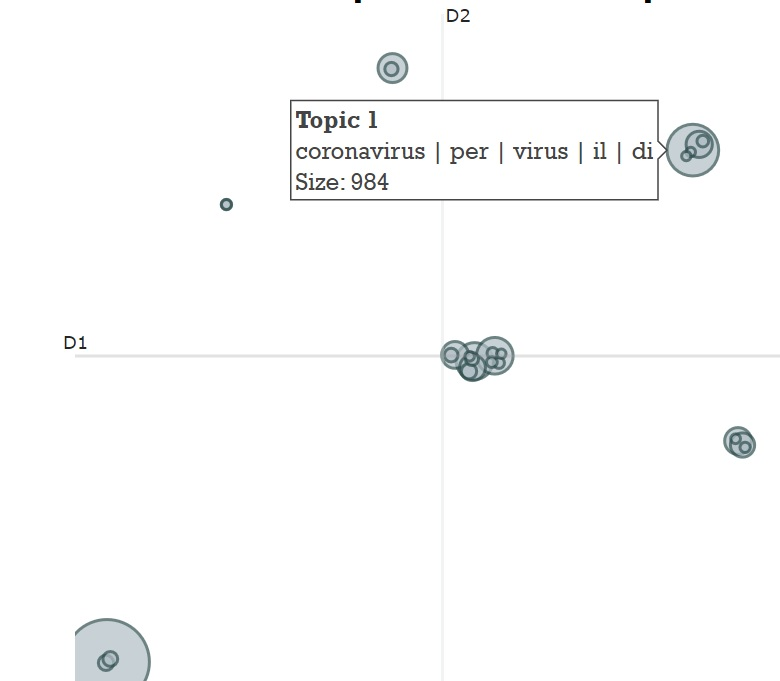

**coronavirus** is in **Topic 1**

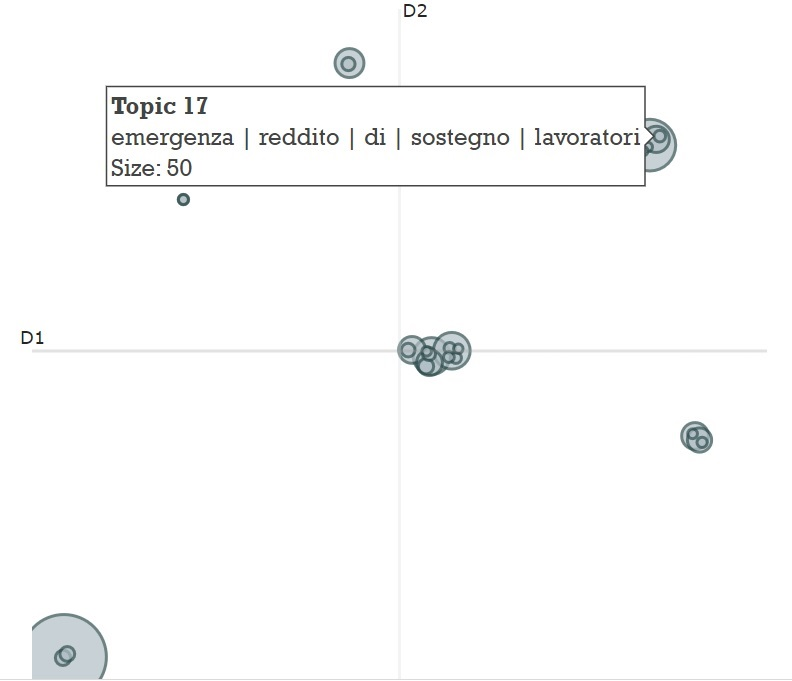

**"reddito"** is very close to "coronavirus" in **Topic 17** overlapped with **Topic 1**

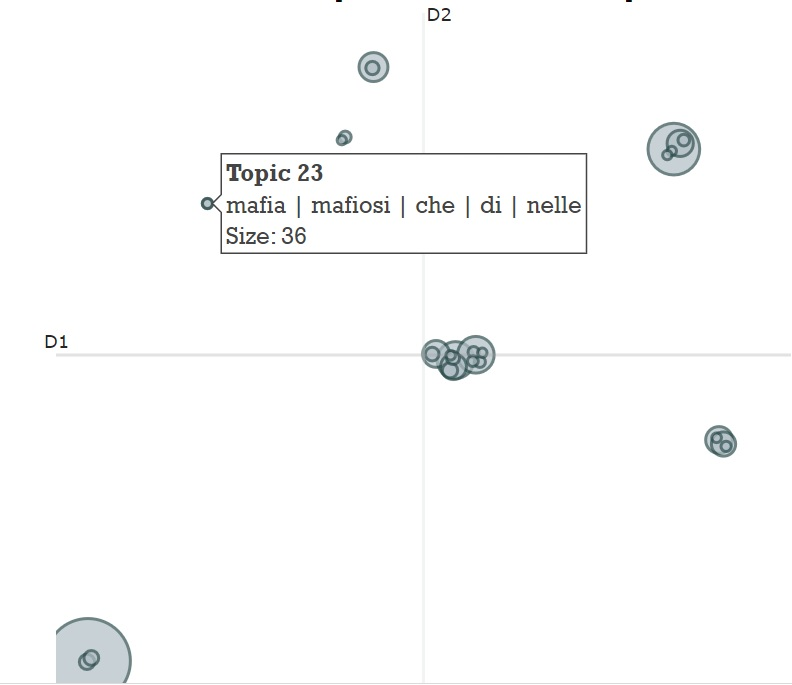

**"mafia"** is very far from **"coronavirus"** and **"reddito"**

While this heatmap shows the similarity between different topics.

In [72]:
topic_model.visualize_heatmap()

<hr>